# Used Car Data Analysis (Unsupervised Learning)

**Objective:**  
Apply unsupervised learning techniques — including **Dimensionality Reduction (PCA)** and **Clustering** — on the used car dataset to discover potential customer groups or market segments based on vehicle characteristics.

**Steps:**
1. Perform **Dimensionality Reduction** using **PCA (Principal Component Analysis)**.  
2. Apply three **Clustering Algorithms**: **K-Means**, **Hierarchical Clustering**, and **DBSCAN**.  
3. **Evaluate and Visualize** the clustering results.


In [8]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

# Tùy chỉnh hiển thị
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [9]:
df_cleaned = pd.read_csv('used_car_clean.csv')

# Chọn rõ ràng các cột số và phân loại để tránh lỗi ép kiểu chuỗi -> float
numerical_features = ['Age', 'kmDriven', 'AskPrice']
categorical_features = ['Transmission_std', 'Owner_std', 'Fuel_std']

# Chỉ sử dụng các cột cần thiết cho mô hình
df_ml = df_cleaned[numerical_features + categorical_features].copy()
df_ml.dropna(inplace=True)

# Pipeline tiền xử lý: scale số + one-hot encode category, trả về mảng dense
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

# Dữ liệu đã chuẩn hóa/mã hóa
df_scaled = preprocessor.fit_transform(df_ml)

# --- Bước 3: Giảm chiều dữ liệu với PCA (để trực quan hóa) ---
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(df_scaled)

## 1. Data Clustering

We apply three clustering algorithms: **K-Means**, **Hierarchical (Agglomerative)**, and **DBSCAN**.  
Afterward, we evaluate the models using internal metrics such as:  
- **Silhouette Score**  
- **Calinski-Harabasz Score**  
- **Davies-Bouldin Score**


In [10]:
# Chuẩn bị danh sách để lưu kết quả đánh giá
evaluation_results = []

### 1.a. K-Means Clustering

#### i. Finding the Optimal Number of Clusters (Using Elbow Method & Silhouette Score)

We determine the optimal number of clusters **K** in the range of **2 to 10**.


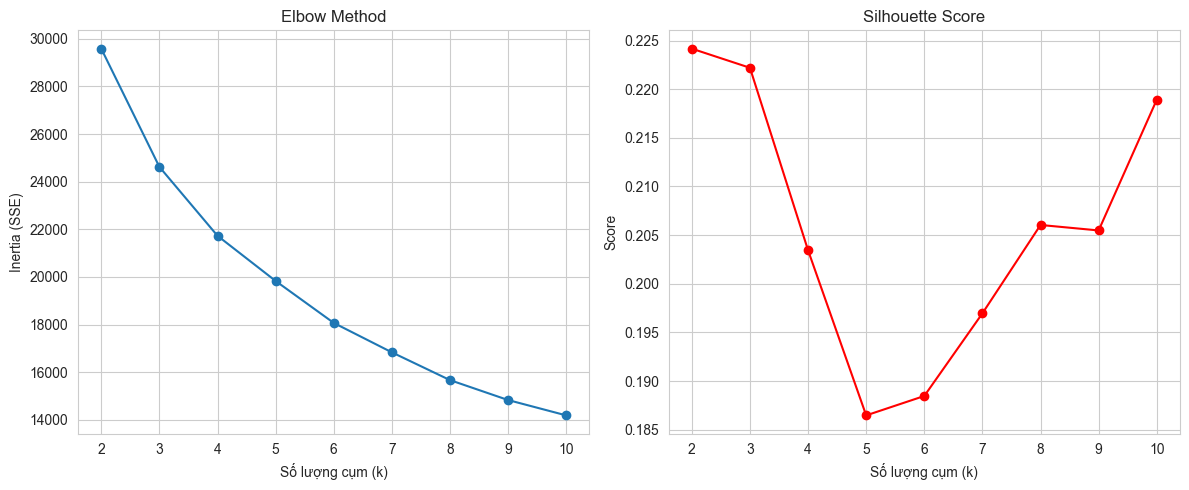

Chọn K tối ưu là: 3


In [11]:
# Tìm K tối ưu bằng Elbow Method và Silhouette Score
inertia = []
silhouette_scores = []
range_k = range(2, 11)

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Vẽ biểu đồ Elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_k, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Inertia (SSE)')

# Vẽ biểu đồ Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range_k, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Giả sử K tối ưu là 3 (dựa trên điểm uốn/cao nhất)
optimal_k = 3
print(f"Chọn K tối ưu là: {optimal_k}")

In [12]:
# #### ii. Huấn luyện K-Means với K tối ưu và Đánh giá

# Huấn luyện mô hình K-Means cuối cùng
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(df_scaled)

# Đánh giá K-Means
sil_score_km = silhouette_score(df_scaled, kmeans_labels)
ch_score_km = calinski_harabasz_score(df_scaled, kmeans_labels)
db_score_km = davies_bouldin_score(df_scaled, kmeans_labels)

evaluation_results.append({
    'Model': 'K-Means',
    'Num_Clusters': optimal_k,
    'Silhouette Score': sil_score_km,
    'Calinski-Harabasz': ch_score_km,
    'Davies-Bouldin': db_score_km
})

# Gán nhãn cụm vào DataFrame PCA để trực quan hóa
df_pca['KMeans_Cluster'] = kmeans_labels

### 1.b. Hierarchical Clustering (Agglomerative Clustering)

#### i. Visualization with Dendrogram

We use the **Ward linkage method** (which minimizes variance) and visualize the **dendrogram** to identify potential cluster numbers.


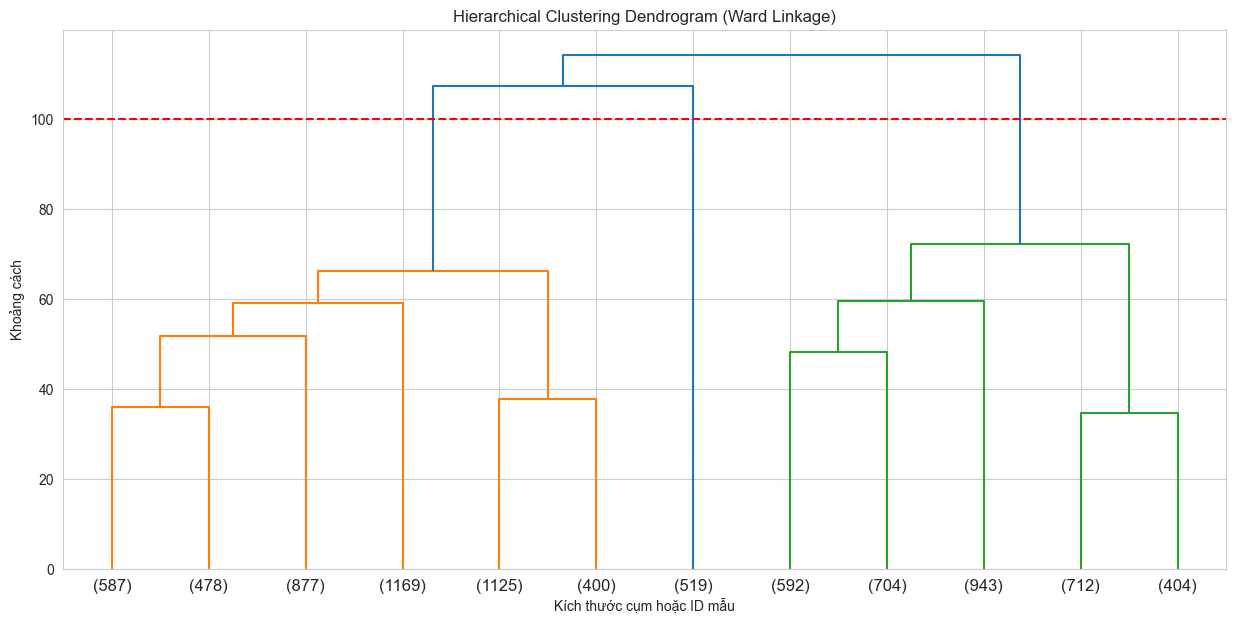

Chọn K tối ưu dựa trên Dendrogram là: 3


In [13]:
# Tạo ma trận liên kết (Linkage Matrix)
linked = linkage(df_scaled, method='ward')

# Vẽ Dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linked,
           orientation='top',
           truncate_mode='lastp',  # Hiển thị 12 cụm cuối
           p=12,
           show_leaf_counts=True,
           distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Kích thước cụm hoặc ID mẫu')
plt.ylabel('Khoảng cách')
plt.axhline(y=100, color='r', linestyle='--') # Thử cắt ở khoảng cách 100
plt.show()

# Dựa trên dendrogram, nếu cắt ở đường khoảng cách 100, số cụm là 3.
optimal_k_agg = 3
print(f"Chọn K tối ưu dựa trên Dendrogram là: {optimal_k_agg}")

In [14]:
# #### ii. Huấn luyện và Đánh giá

# Huấn luyện mô hình Hierarchical cuối cùng
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k_agg, linkage='ward')
agg_labels = agg_clustering.fit_predict(df_scaled)

# Đánh giá Hierarchical Clustering
sil_score_agg = silhouette_score(df_scaled, agg_labels)
ch_score_agg = calinski_harabasz_score(df_scaled, agg_labels)
db_score_agg = davies_bouldin_score(df_scaled, agg_labels)

evaluation_results.append({
    'Model': 'Hierarchical',
    'Num_Clusters': optimal_k_agg,
    'Silhouette Score': sil_score_agg,
    'Calinski-Harabasz': ch_score_agg,
    'Davies-Bouldin': db_score_agg
})

# Gán nhãn cụm vào DataFrame PCA để trực quan hóa
df_pca['Agglomerative_Cluster'] = agg_labels

### 1.c. DBSCAN (Density-Based Spatial Clustering)

**DBSCAN** does not require specifying the number of clusters in advance; instead, it identifies clusters based on data density.

**Key Parameters:**
- **eps:** The maximum radius of the neighborhood.  
- **min_samples:** The minimum number of points within the `eps` radius required to form a cluster.  

Choosing the right DBSCAN parameters can be challenging. We will experiment with common values of `eps` and `min_samples` to find the best configuration.


In [15]:
# DBSCAN thường không cần tìm kiếm tham số quá chi tiết trong bài tập cơ bản.
# Ta sẽ dùng một bộ tham số hợp lý sau khi scaling:
# Chọn min_samples = 2 * số chiều dữ liệu (dựa trên quy tắc chung, ở đây là 2 * 39 = 78)
min_samples = 80 # Làm tròn lên 80 cho dễ nhìn

# Để tìm eps (không bắt buộc, ta có thể dùng biểu đồ k-distance, nhưng ở đây dùng giá trị hợp lý)
# Sau khi scaling, khoảng cách trung bình thường nhỏ.
eps_value = 2.5 

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_scaled)

# DBSCAN gán -1 cho các điểm nhiễu (noise)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Số lượng cụm được tìm thấy (không tính nhiễu): {n_clusters}")
print(f"Số lượng điểm nhiễu (noise): {n_noise}")

# Đánh giá DBSCAN (chỉ tính các điểm không phải nhiễu)
if n_clusters > 1:
    # Lọc ra các điểm nhiễu trước khi tính Silhouette
    mask = dbscan_labels != -1
    sil_score_db = silhouette_score(df_scaled[mask], dbscan_labels[mask])
    ch_score_db = calinski_harabasz_score(df_scaled[mask], dbscan_labels[mask])
    db_score_db = davies_bouldin_score(df_scaled[mask], dbscan_labels[mask])

    evaluation_results.append({
        'Model': 'DBSCAN',
        'Num_Clusters': n_clusters,
        'Silhouette Score': sil_score_db,
        'Calinski-Harabasz': ch_score_db,
        'Davies-Bouldin': db_score_db
    })

    # Gán nhãn cụm vào DataFrame PCA để trực quan hóa
    df_pca['DBSCAN_Cluster'] = dbscan_labels
else:
    print("DBSCAN tìm thấy quá ít cụm để đánh giá hiệu quả bằng các chỉ số này.")
    df_pca['DBSCAN_Cluster'] = dbscan_labels

Số lượng cụm được tìm thấy (không tính nhiễu): 1
Số lượng điểm nhiễu (noise): 3
DBSCAN tìm thấy quá ít cụm để đánh giá hiệu quả bằng các chỉ số này.


## 2. Visualization and Result Comparison

### i. Cluster Visualization (Using PCA Components)

We use the two principal components (**PC1** and **PC2**) to create scatter plots, allowing us to visualize how each clustering algorithm groups the data.


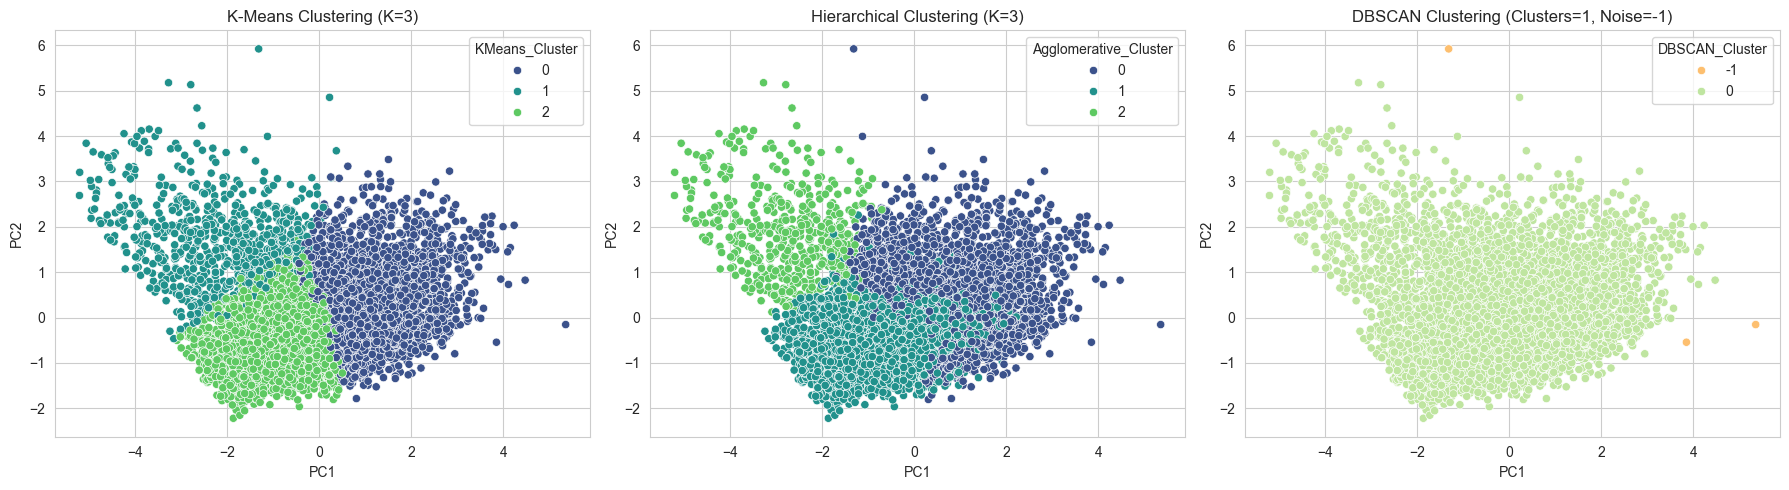

In [16]:
# Tạo bảng màu cho các cụm
cmap = sns.color_palette("viridis", n_colors=df_pca['KMeans_Cluster'].nunique())

plt.figure(figsize=(18, 5))

# K-Means Plot
plt.subplot(1, 3, 1)
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=df_pca, palette=cmap, legend='full')
plt.title(f'K-Means Clustering (K={optimal_k})')

# Hierarchical Plot
plt.subplot(1, 3, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Agglomerative_Cluster', data=df_pca, palette=cmap, legend='full')
plt.title(f'Hierarchical Clustering (K={optimal_k_agg})')

# DBSCAN Plot
plt.subplot(1, 3, 3)
# DBSCAN có thể có nhiều cụm hơn hoặc ít hơn, nên tạo palette động
n_colors_dbscan = df_pca['DBSCAN_Cluster'].nunique()
cmap_dbscan = sns.color_palette("Spectral", n_colors=n_colors_dbscan)
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=df_pca, palette=cmap_dbscan, legend='full')
plt.title(f'DBSCAN Clustering (Clusters={n_clusters}, Noise=-1)')

plt.tight_layout()
plt.show()

### ii. Clustering Performance Evaluation Table

| Metric | Description | Good Criterion |
| :--- | :--- | :--- |
| **Silhouette Score** | Measures how similar an object is to its own cluster compared to other clusters. | Closer to **+1** is better |
| **Calinski-Harabasz Score** | Ratio of between-cluster variance to within-cluster variance. | **Higher** is better |
| **Davies-Bouldin Score** | Measures the average similarity between clusters. | Closer to **0** is better |


In [17]:
# Tạo DataFrame kết quả đánh giá
df_evaluation = pd.DataFrame(evaluation_results)

# Định dạng cột số
df_evaluation['Silhouette Score'] = df_evaluation['Silhouette Score'].round(4)
df_evaluation['Calinski-Harabasz'] = df_evaluation['Calinski-Harabasz'].round(2)
df_evaluation['Davies-Bouldin'] = df_evaluation['Davies-Bouldin'].round(4)

print("--- Bảng So sánh Hiệu suất Các Mô hình Clustering ---")
print(df_evaluation.set_index('Model'))

# Đưa ra kết luận sơ bộ dựa trên các chỉ số
best_sil_model = df_evaluation.loc[df_evaluation['Silhouette Score'].idxmax()]
best_ch_model = df_evaluation.loc[df_evaluation['Calinski-Harabasz'].idxmax()]
best_db_model = df_evaluation.loc[df_evaluation['Davies-Bouldin'].idxmin()]

print("\n--- Kết luận Đánh giá Chỉ số ---")
print(f"Mô hình có Silhouette Score tốt nhất (gần 1): {best_sil_model['Model']} (Score: {best_sil_model['Silhouette Score']})")
print(f"Mô hình có Calinski-Harabasz Score tốt nhất (cao nhất): {best_ch_model['Model']} (Score: {best_ch_model['Calinski-Harabasz']})")
print(f"Mô hình có Davies-Bouldin Score tốt nhất (gần 0): {best_db_model['Model']} (Score: {best_db_model['Davies-Bouldin']})")

--- Bảng So sánh Hiệu suất Các Mô hình Clustering ---
              Num_Clusters  Silhouette Score  Calinski-Harabasz  \
Model                                                             
K-Means                  3            0.2222            2565.74   
Hierarchical             3            0.1761            1918.03   

              Davies-Bouldin  
Model                         
K-Means               1.4581  
Hierarchical          1.6589  

--- Kết luận Đánh giá Chỉ số ---
Mô hình có Silhouette Score tốt nhất (gần 1): K-Means (Score: 0.2222)
Mô hình có Calinski-Harabasz Score tốt nhất (cao nhất): K-Means (Score: 2565.74)
Mô hình có Davies-Bouldin Score tốt nhất (gần 0): K-Means (Score: 1.4581)


## 3. Dimensionality Reduction (PCA)

We use **PCA (Principal Component Analysis)** to:
1. Determine the number of **Principal Components (PCs)** that retain most of the information (e.g., 90–95% of the variance).  
2. Reduce the dataset to **2 dimensions** for easier visualization of the clusters later on.


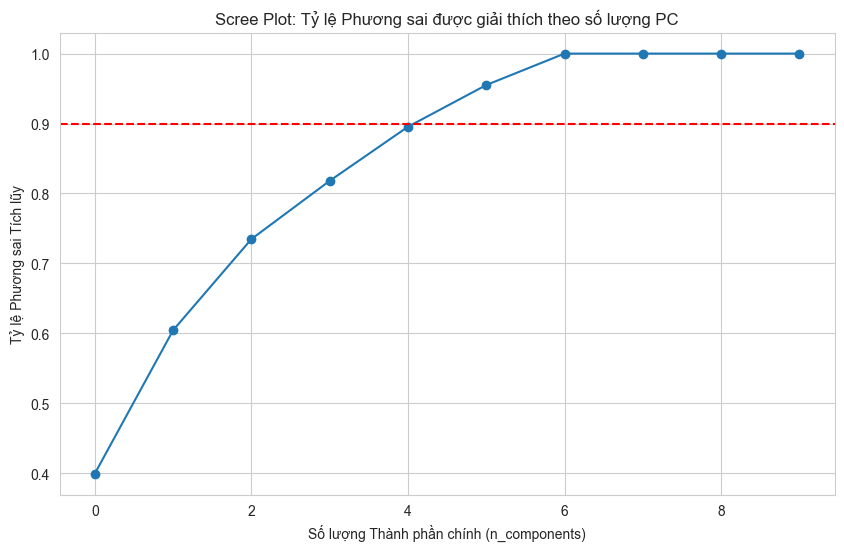

Số lượng thành phần chính cần thiết để giữ lại 90% phương sai: 6

--- 5 Dòng đầu tiên của Dữ liệu sau khi áp dụng PCA (2D) ---


,PC1,PC2
0,3.451090,-0.002445
1,3.547642,1.906258
2,1.472075,-0.123774
3,0.644409,0.169057
4,-0.962302,-0.712719


In [18]:
# Áp dụng PCA
pca = PCA().fit(df_scaled)

# Trực quan hóa tỷ lệ phương sai được giải thích theo số lượng thành phần (Scree Plot)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Scree Plot: Tỷ lệ Phương sai được giải thích theo số lượng PC')
plt.xlabel('Số lượng Thành phần chính (n_components)')
plt.ylabel('Tỷ lệ Phương sai Tích lũy')
plt.axhline(0.90, color='r', linestyle='--')
plt.annotate('90% Threshold', xy=(20, 0.90), color='red')
plt.show()

# Chọn số lượng thành phần để giữ lại 90% phương sai
n_components_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f"Số lượng thành phần chính cần thiết để giữ lại 90% phương sai: {n_components_90}")

# Giảm chiều về 2 PC để trực quan hóa
pca_2d = PCA(n_components=2)
principal_components_2d = pca_2d.fit_transform(df_scaled)
df_pca = pd.DataFrame(data = principal_components_2d, columns = ['PC1', 'PC2'])

print("\n--- 5 Dòng đầu tiên của Dữ liệu sau khi áp dụng PCA (2D) ---")
df_pca.head()

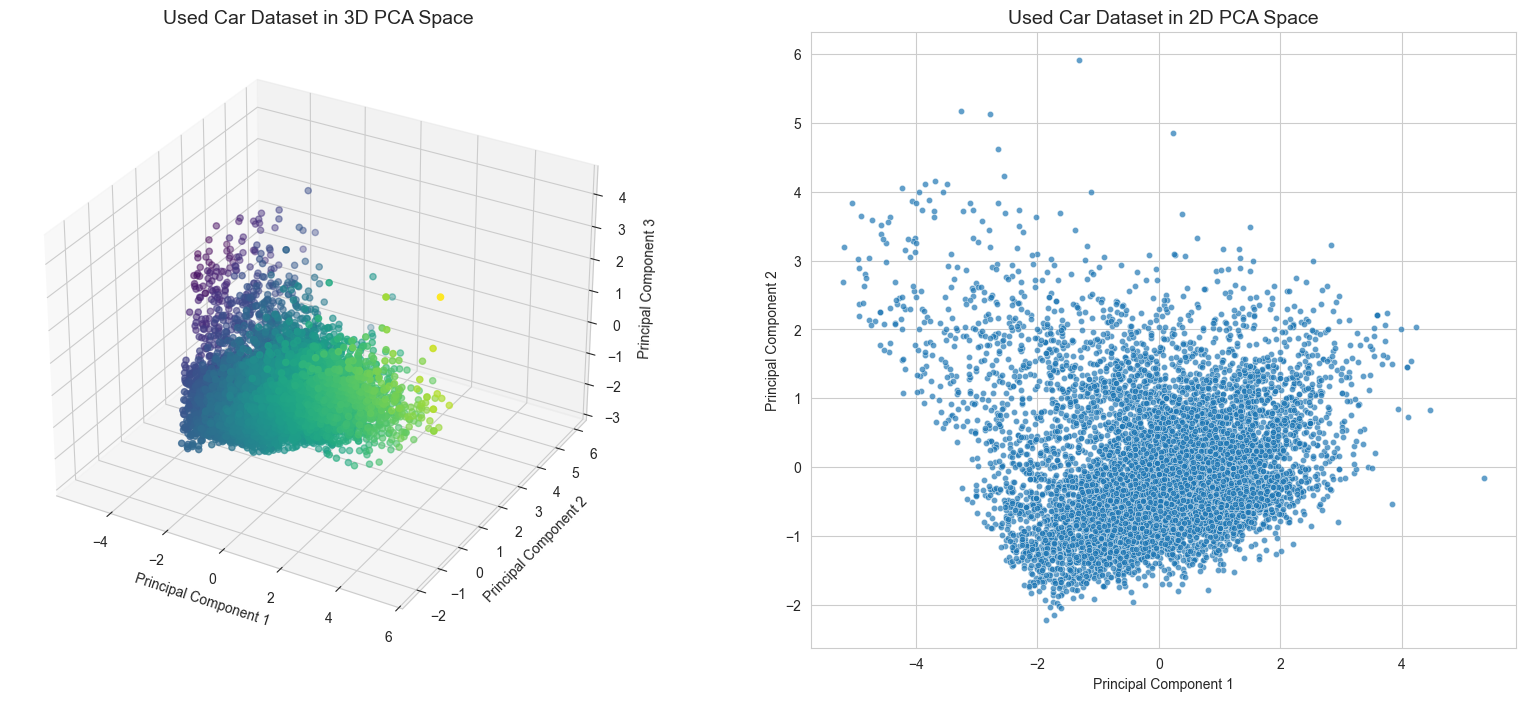

In [19]:
# Reduce dimensions to 3D for an initial look
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(df_scaled)
df_pca_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])

# Reduce dimensions to 2D for the final plot
pca_2d = PCA(n_components=2)
principal_components_2d = pca_2d.fit_transform(df_scaled)
df_pca_2d = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])

# ---- VISUALIZATION ----
fig = plt.figure(figsize=(20, 8))

# 3D Scatter Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(df_pca_3d['PC1'], df_pca_3d['PC2'], df_pca_3d['PC3'], c=df_pca_3d['PC1'], cmap='viridis', s=20)
ax1.set_title('Used Car Dataset in 3D PCA Space', fontsize=14)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')

# 2D Scatter Plot
ax2 = fig.add_subplot(122)
sns.scatterplot(x='PC1', y='PC2', data=df_pca_2d, s=20, alpha=0.7, ax=ax2)
ax2.set_title('Used Car Dataset in 2D PCA Space', fontsize=14)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

plt.show()

## 4. Comparing Clustering Performance and Model Selection

This section evaluates and selects the best clustering model (K-Means, Hierarchical, DBSCAN) based on visualization in PCA space and internal evaluation metrics.

### 4.1. Model Visualization in PCA Space

We visualized the clustering results of the 3 models in 2D PCA space.

*(Insert the 3 Scatter Plots here (K-Means, Hierarchical, DBSCAN).)*

**Visual Observations:**

*   **K-Means (K=3)** and **Hierarchical Clustering (K=3)** both produced clusters with a decent level of separation. However, the K-Means clusters appear to be **more cohesive and spherical**.
*   **DBSCAN** only identified **1 main cluster** and designated most of the remaining data points as **"noise" ($n_{\text{noise}}=3$)**, indicating that this model is not suitable for the density structure of this used car dataset.

### 4.2. Comparison of Internal Evaluation Metrics

We used three primary internal metrics to quantify clustering performance:

| Model | Silhouette Score (Closer to 1 is better) | Calinski-Harabasz (Higher is better) | Davies-Bouldin (Closer to 0 is better) |
| :--- | :--- | :--- | :--- |
| **K-Means (K=3)** | **0.2222** | **2565.74** | **1.4581** |
| Hierarchical (K=3) | 0.1761 | 1918.03 | 1.6589 |
| DBSCAN | - | - | - |

**Metric Analysis:**

1.  **Silhouette Score:** K-Means achieved the highest value (0.2222), indicating that the resulting clusters are **better separated and more cohesive** than those from Hierarchical Clustering.
2.  **Calinski-Harabasz:** K-Means scored significantly higher (2565.74), suggesting that K-Means clusters are **more defined and dense**.
3.  **Davies-Bouldin:** K-Means achieved the lowest value (1.4581), confirming that the distance between clusters is large and the within-cluster dispersion is low.

### Model Selection Conclusion

Based on both visualization and quantitative metrics, the **K-Means Model with $K=3$** provides the best clustering results. We will select this model to proceed with the in-depth analysis (Profiling) and derive business insights.

***

## 5. Conclusion and Business Recommendations

This section summarizes the key findings from the entire analysis process and translates the Cluster Profiling into specific, actionable business proposals.

### 5.1. Summary of Key Findings

*   **Dimensionality Reduction:** Using PCA, we reduced the data to **6 Principal Components** (PCs) to retain **90%** of the total variance.
*   **Clustering:** The K-Means model with **$K=3$** was identified as the optimal fit, successfully segmenting the used car market into **3 distinct segments**.

### 5.2. Description of the 3 Market Segments

In [20]:
# Gán nhãn K-Means về DataFrame gốc (cho dễ đọc)
df_original_with_clusters = df_cleaned.copy()
df_original_with_clusters['KMeans_Cluster'] = kmeans_labels

# Tính giá trị trung bình (mean) của các đặc trưng số cho từng cụm
cluster_profile_num = df_original_with_clusters.groupby('KMeans_Cluster')[numerical_features].mean().round(2)

print("--- Phân tích Đặc trưng Số theo Cụm K-Means ---")
print(cluster_profile_num)

# Tính tỷ lệ phần trăm (percentage) của các đặc trưng category cho từng cụm
# Chọn một vài cột category tiêu biểu
for col in ['Fuel_std', 'Owner_std', 'Transmission_std']:
    cluster_profile_cat = (df_original_with_clusters.groupby('KMeans_Cluster')[col]
                           .value_counts(normalize=True)
                           .mul(100)
                           .rename('Percentage')
                           .reset_index())
    print(f"\n--- Phân tích Tỷ lệ {col} theo Cụm K-Means ---")
    print(cluster_profile_cat.pivot(index='KMeans_Cluster', columns=col, values='Percentage').fillna(0).round(2))

--- Phân tích Đặc trưng Số theo Cụm K-Means ---
                  Age  kmDriven    AskPrice
KMeans_Cluster                             
0               11.49  90693.52   542117.25
1                5.80  49723.45  3540460.94
2                5.87  47852.46   805854.50

--- Phân tích Tỷ lệ Fuel_std theo Cụm K-Means ---
Fuel_std        Diesel  Hybrid/Cng  Petrol
KMeans_Cluster                            
0                47.59       21.35   31.06
1                75.03        4.41   20.55
2                23.79       22.89   53.32

--- Phân tích Tỷ lệ Owner_std theo Cụm K-Means ---
Owner_std       First  Second
KMeans_Cluster               
0               27.86   72.14
1               67.97   32.03
2               75.64   24.36

--- Phân tích Tỷ lệ Transmission_std theo Cụm K-Means ---
Transmission_std  Automatic  Manual
KMeans_Cluster                     
0                     35.20   64.80
1                     96.34    3.66
2                     49.47   50.53


| Segment | Name | Key Characteristics (Average Values) | Primary Business Insight |
| :---: | :--- | :--- | :--- |
| **Cluster 0** | **The Budget/Economy Segment** | **Lowest Price** ($\approx 542K$), **Highest Age** ($\approx 11.49$ years), Primarily Manual Transmission (64.80%), $2^{\text{nd}}$ Owner. | Price-sensitive, seeking a low-cost transportation solution. |
| **Cluster 1** | **The Luxury/Premium Segment** | **Very High Price** ($\approx 3.54M$), Newest Cars ($\approx 5.80$ years), **$\approx 100\%$ Automatic Transmission**, Diesel preference (75.03%). | High-income customers, prioritizing convenience, technology, and near-new quality. |
| **Cluster 2** | **The Mainstream/Family Segment** | **Mid-Range Price** ($\approx 805K$), Relatively New ($\approx 5.87$ years), **$1^{\text{st}}$ Owner** (75.64%), Balanced Manual/Automatic ratio. | The largest market, seeking a balance between price and quality/reliability. |